<a href="https://colab.research.google.com/github/SebastianGhafafian/Circle_CNN/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project sets up a relatively simple task for a ConvNN. A image contains a circle or random size and position. The goal is to output the position and the size of the circle.
The training and test data was created using the .... script.
This project is aimed at deepening the understanding of the framework and to play more with parameters while keeping the problem set up relatively simple.

A noise filter is added that allows to train on the same data set being able to set a noise level as a transformer. The model is trained for different noise level to see how far it can be pushed.

In [ ]:
#Import the libraries
import zipfile
import os
# extract new data
zip_training = zipfile.ZipFile('./data/dataset_mid.zip', 'r') #Opens the zip file in read mode
zip_training.extractall() #Extracts the files into the /tmp folder
zip_training.close()


In [11]:
# import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import Circle
import utils
import networks

4000 16000
117


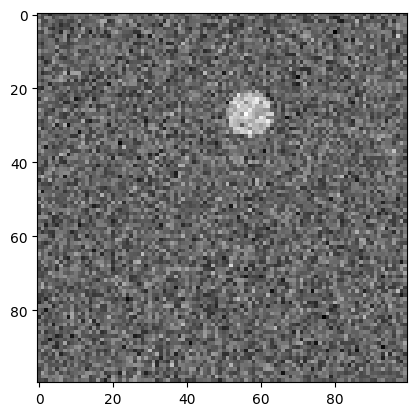

In [29]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # get labels
        self.img_dir = img_dir # store image directory
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        xlabel = self.img_labels.iloc[idx, 1]
        ylabel = self.img_labels.iloc[idx, 2]
        radius = self.img_labels.iloc[idx, 3]
        # apply input transformation
        if self.transform:
            image = self.transform(image)
        # apply target transformation
        if self.target_transform:
            xlabel = self.target_transform(xlabel)
            ylabel = self.target_transform(ylabel)
            radius = self.target_transform(radius)

        return image, np.array([xlabel,ylabel,radius],dtype=np.float32) ####how to I work with
    


# define the train and val splits
train_split = 0.80
test_split = 1 - train_split
#Hyperparameters
learning_rate = 5e-4
batch_size = 100
epochs = 5
noise_lvl = 0.3

#add gassian noise to training data
data_set = CustomImageDataset(annotations_file="./data/annotations.csv",img_dir="./data",transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    utils.AddGaussianNoise(mean = 0, std = noise_lvl)]))

# set number of training samples
numTrainingSamples = int(len(data_set) * train_split)
# set number of test samples
numTestSamples = int(len(data_set) - numTrainingSamples)
print(numTestSamples, numTrainingSamples)
# draw randomly from data
(trainData, testData) = random_split(data_set,
	[numTrainingSamples, numTestSamples],
	generator=torch.Generator().manual_seed(42))

# define data loader of batch size 50
train_dataloader = DataLoader(trainData, batch_size=50, shuffle=True)
test_dataloader = DataLoader(testData, batch_size=50, shuffle=True)


#draw random sample to verify noisy image is created
sample_idx = torch.randint(len(trainData), size=(1,)).item()
img, label = trainData[319]
plt.imshow(img.squeeze(), cmap = "gray")

label.dtype
print(sample_idx)
torch.max(img)
plt.savefig(f'img319_{noise_lvl}.png')

In [ ]:


model = networks.CustomCNN3()
model = NeuralNetwork()
model = LeNet(1,3)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
#print(f"Ratio of samples/parameters: 1:{np.round(total_params/len(trainData.img_labels),1)}")

In [30]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)
model = networks.CustomCNN3().to(device)
#model = NeuralNetwork().to(device)
#model = LeNet(1,3).to(device)


cpu


In [31]:
# Initialize the loss function
loss_fn = nn.MSELoss()
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, label) in enumerate(dataloader):
        X = X.to(device)
        label = label.to(device)
        # Compute prediction and loss
        pred = torch.squeeze(model(X))
        loss = loss_fn(pred, label)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, label in dataloader:
            X = X.to(device)
            label = label.to(device)
            pred = torch.squeeze(model(X))
            test_loss += loss_fn(pred, label).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

#initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [32]:
testing_loss = []

Epoch 1
-------------------------------
loss: 1931.724609  [   50/16000]
loss: 763.537598  [ 1050/16000]
loss: 576.744141  [ 2050/16000]
loss: 252.067657  [ 3050/16000]
loss: 59.576679  [ 4050/16000]
loss: 95.645485  [ 5050/16000]
loss: 40.894333  [ 6050/16000]
loss: 60.807564  [ 7050/16000]
loss: 26.237490  [ 8050/16000]
loss: 42.210030  [ 9050/16000]
loss: 16.333263  [10050/16000]
loss: 34.840736  [11050/16000]
loss: 17.466290  [12050/16000]
loss: 9.157670  [13050/16000]
loss: 7.452809  [14050/16000]
loss: 13.186325  [15050/16000]
Test Error: 
 Avg loss: 27.977285 

Epoch 2
-------------------------------
loss: 19.715120  [   50/16000]
loss: 5.407221  [ 1050/16000]
loss: 6.343461  [ 2050/16000]
loss: 6.178324  [ 3050/16000]
loss: 18.016666  [ 4050/16000]
loss: 13.641392  [ 5050/16000]
loss: 5.138787  [ 6050/16000]
loss: 14.822031  [ 7050/16000]
loss: 4.362833  [ 8050/16000]
loss: 14.814051  [ 9050/16000]
loss: 6.331964  [10050/16000]
loss: 4.843862  [11050/16000]
loss: 3.693732  [120

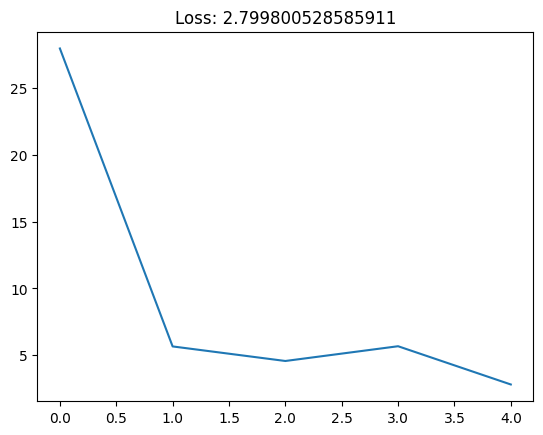

In [33]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    L = test_loop(test_dataloader, model, loss_fn)
    testing_loss.append(L)
print("Done!")
plt.figure()
plt.title(f"Loss: {min(testing_loss)}")
plt.plot(np.arange(len(testing_loss)),testing_loss)

# Export model


In [34]:
df = pd.DataFrame({'test_id':testData.indices})
df.to_csv(f'{model.__class__.__name__} (N: {noise_lvl}) test_idx.csv')

In [35]:

# create a training history data frame
loss_df = pd.DataFrame({f'Loss':testing_loss})
loss_df.to_csv(f'{model.__class__.__name__} (N: {noise_lvl}).csv')

with open(f'{model.__class__.__name__}_state_noise_lvl_{noise_lvl}.pt', 'wb') as f:
    torch.save(model.state_dict(), f)
    print('model has been saved')

model has been saved


# Model evaluation

Model evaluation takes place on multiple levels. On sample level, a random sample is drawn and labels and predicted values are compared visually. This allows to gain some intuition of what might be going wrong or not as intended.
On a higher level the histograms of true labels and and predicted labels are compared to detect weaknesses of the model.
Is it more difficult for the model to predict labels fro circles being at the edge of the picture?
How many weights had to be trained vs the amount of available data?



In [ ]:
# single value random evaluation
model.eval() # what is that
eval_id = torch.randint(len(testData), size=(1,)).item()
X, x0 = testData[eval_id][0], testData[eval_id][1]
with torch.no_grad():
    X = X.unsqueeze(1)
    X = X.to(device)
    pred = model(X)
    predicted, actual = pred, x0
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [ ]:
'\hat{i}'

In [ ]:
# visualize the model performance using the images

# set up a canvas of 3 x 3 subplots
plt.rcParams['figure.figsize'] = [10, 10]
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
fig, axes = plt.subplots( rows, cols )

# plot image and prediction
for i in range(rows):
   for j in range(cols):
      # get random index of test sample
      sample_idx = torch.randint(len(testData), size=(1,)).item()
      # get random test sample
      img, label = testData[sample_idx]
      # whats happening here???
      img.unsqueeze_(1)
      # set image to device
      img = img.to(device)
      # get prediction vector (x,y,r) from model
      pred = model(img).squeeze()
      # what does .item() do ???
      x_pred, y_pred, r_pred = pred[0].item(), pred[1].item(), pred[2].item()

      img = img.to('cpu')
      # figure.add_subplot(rows, cols, i)
      axes[i,j].set_title(f" Labels: x: {label[0]}, y: {label[1]}, r: {label[2]}\n  Pred.:  x: {x_pred:.1f}, y: {y_pred:.1f}, r: {r_pred:.1f}")
      axes[i,j].axis("off")
      axes[i,j].imshow(img.squeeze(), cmap="gray") #what does this do???
      axes[i,j].hlines([x_pred,x_pred],0,100)
      axes[i,j].vlines([y_pred,y_pred],0,100)
      circ = Circle((y_pred,x_pred),r_pred,fill = False, edgecolor = "r")
      axes[i,j].add_patch(circ)


In [ ]:
# instantiate model
conv = NeuralNetwork()

# load weights if they haven't been loaded
# skip if you're directly importing a pretrained network
checkpoint = torch.load('model_state_noise_lvl_0.5.pt')
conv.load_state_dict(checkpoint)


In [ ]:
conv.L1[0]


In [ ]:

import torchvision# get the kernels from the first layer
# as per the name of the layer
kernels = conv.L1[0].weight.detach().clone()
kernels = conv.L1[0].weight.detach().clone()

# normalize to (0,1) range so that matplotlib
# can plot them
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = torchvision.utils.make_grid(kernels, nrow = 12)
# change ordering since matplotlib requires images to 
# be (H, W, C)
plt.imshow(filter_img.permute(1, 2, 0))

# You can directly save the image as well using
img = save_image(kernels, 'encoder_conv1_filters.png' ,nrow = 12)

In [ ]:
import seaborn as sns
# there is a problem in the data creation, x0, y0 should be uniform
sns.histplot(data = training_data.img_labels, x = 'x0',bins = 20)
sns.histplot(data = training_data.img_labels, x = 'y0',bins = 20)
plt.show()
sns.histplot(data = training_data.img_labels, x = 'r',bins = 10)

In [ ]:
compare_df = test_data.img_labels

compare_df.iloc[0]['x0']


In [ ]:
r_hat = np.zeros(len(compare_df))
x_hat = np.zeros_like(r_hat)
y_hat = np.zeros_like(r_hat)
for i,(img, _) in enumerate(test_data):
      # whats happening here???
      img.unsqueeze_(1)
      # set image to device
      img = img.to(device)
      # get prediction vector (x,y,r) from model
      pred = model(img).squeeze()
      # what does .item() do ???
      x_hat[i] = pred[0].item()
      y_hat[i] = pred[1].item()
      r_hat[i] = pred[2].item()
      if i % 200 == 0:
        print('{}/{}'.format(i,len(compare_df)))
compare_df['x_hat'] = x_hat
compare_df['y_hat'] = y_hat
compare_df['r_hat'] = r_hat


In [ ]:
compare_df

In [ ]:
import seaborn as sns
# there is a problem in the data creation, x0, y0 should be uniform
sns.histplot(data = compare_df, x = 'x0',bins = 20)
sns.histplot(data = compare_df, x = 'x_hat',bins = 20)
plt.show()
sns.histplot(data = compare_df, x = 'y0',bins = 20)
sns.histplot(data = compare_df, x = 'y_hat',bins = 20)
plt.show()
sns.histplot(data = compare_df, x = 'r',bins = 20)
sns.histplot(data = compare_df, x = 'r_hat',bins = 30)
plt.show()

In [ ]:
from torch import nn, save, load
with open(f'model_state_noise_lvl_{noise_lvl}.pt', 'wb') as f:
    save(model.state_dict(), f)

In [ ]:
os.getcwd()